# Road segmentation: Train-Test

The aim of this notebook is to:

- Split the training dataset into a train and a test set
- Train the U-Net neural network on the training set
- Test the model on the test set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import torch
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import transforms

# Add root directory to path
ROOT_DIR = os.path.dirname(os.getcwd())
sys.path.append(ROOT_DIR)

from src.datasets import SatelliteImagesDataset, train_test_split
from src.nets import UNet
from src.path import (DATA_TRAIN_GT_PATH, DATA_TRAIN_IMG_PATH, MODELS_DIR,
                      create_dirs, extract_archives)
from src.plot_utils import plot_loss, plot_images
from src.trainer import Trainer

In [3]:
# Config
BATCH_SIZE = 1
EPOCHS = 10
IMG_HEIGHT = 400
IMG_WIDTH = 400
LR = 1e-3
SEED = 0
SPLIT_RATIO = 0.2
WORKERS = 4

# Paths
timestr = time.strftime('%Y%m%d')

model_filename = f'model-train-test-{timestr}.pt'
print('Model file:', model_filename)
MODEL_PATH = os.path.join(MODELS_DIR, model_filename)

log_filename = f'log-train-test-{timestr}.pickle'
print('Log file:', log_filename)
LOG_PATH = os.path.join(MODELS_DIR, log_filename)

Model file: model-train-test-20211125.pt
Log file: log-train-test-20211125.pickle


In [4]:
# Extract archives and create directories if needed
create_dirs()
extract_archives()

In [5]:
# Set seed
torch.manual_seed(SEED)

In [6]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
pin_memory = device == 'cuda'

Device: cpu


In [7]:
# Define transforms
image_transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
])

# Define dataset
dataset = SatelliteImagesDataset(
    img_dir=DATA_TRAIN_IMG_PATH,
    gt_dir=DATA_TRAIN_GT_PATH,
    image_transform=image_transform,
    mask_transform=mask_transform,
)
print('Size of dataset:', len(dataset))

Size of dataset: 100


Image size: torch.Size([3, 400, 400])
Mask size: torch.Size([1, 400, 400])


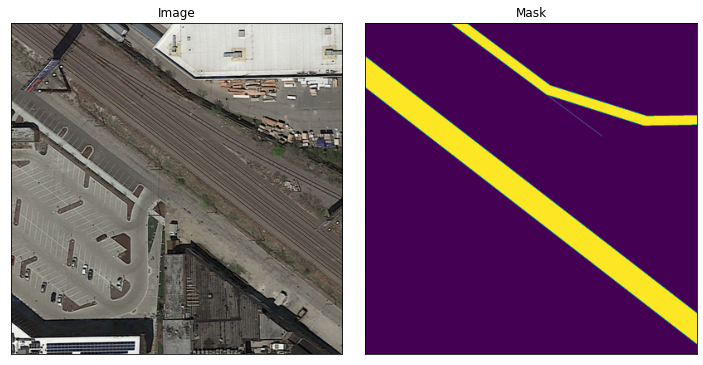

In [8]:
# Sample of image/mask
image, mask = dataset[0]
print('Image size:', image.shape)
print('Mask size:', mask.shape)
plot_images(image, mask)

In [9]:
# Split train test
train_set, test_set = train_test_split(dataset=dataset, test_ratio=SPLIT_RATIO)
print('Train size:', len(train_set))
print('Test size:', len(test_set))

# Define loaders
train_loader = DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)
test_loader = DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=WORKERS,
    pin_memory=pin_memory,
)

Train size: 80
Test size: 20


In [10]:
# Define neural net
model = UNet()
model.to(device)

UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [11]:
# Define loss function and optimizer
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LR)

In [12]:
# Define trainer
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    epochs=EPOCHS,
    device=device,
    weights_path=MODEL_PATH,
    log_path=LOG_PATH,
    data_loader=train_loader,
    valid_data_loader=test_loader,
    notebook=True,
)

In [14]:
# Launch training
trainer.train()

Start training.


Training:   0%|          | 0/10 [00:00<?, ?epoch/s]

Train epoch 1:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 1:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 2:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 2:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 3:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 3:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 4:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 4:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 5:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 5:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 6:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 6:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 7:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 7:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 8:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 8:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 9:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 9:   0%|          | 0/20 [00:00<?, ?batch/s]

Train epoch 10:   0%|          | 0/80 [00:00<?, ?batch/s]

Valid epoch 10:   0%|          | 0/20 [00:00<?, ?batch/s]

End training. Time: 717.636s.


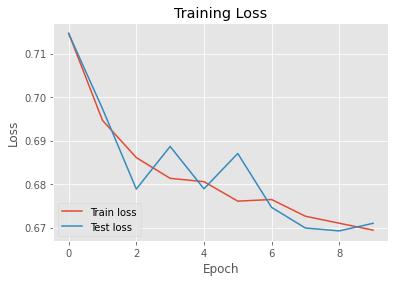

In [15]:
# Plot train test loss
plot_loss(
    train_loss=trainer.history['train_loss'],
    test_loss=trainer.history['test_loss'],
    path=LOG_PATH.replace('.pickle', '.png'),
)